In [2]:
import numpy as np

*backpropagation* is the backbone of every neural networks engine, e.g. pytorch. 
maybe change the name to **chadGrad**, GigaGrad, ScalarFlow

In [115]:
# Value object takes a single scalar value and wraps it
class Value:
    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        # the children nodes resulting in Value object
        self._prev = set(_children)
        # the operation resulting in Value object
        self._op = _op
        # the label for a Value
        self._label = _label
        # by default we assume that a Value doesn't effect the output loss function,
        # this is the gradient of the loss function, L, wrt this specific Value
        self.grad = 0.0
        # the backprop
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self._label})"
    
    # keep track of the children in mul and add ops
    def __add__(self, other):
        # Value(data=2.0) + 1.0
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # here we have to set self.grad and other.grad,
        # out = self + other
        # dL/dself = dL/dout * dout/dself = out.grad * 1
        # dL/dother = dL/dout * dout/dother = out.grad * 1
        def _backward():
            self.grad  += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        # Value(data=2.0) * 1.0
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        # out = self * other
        # dL/dself = dL/out * dout/dself = out.grad * other
        # dL/dother = dL/dout * dout/dother = out.grad * self
        def _backward():
            self.grad  += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        # 1.0 * Value(data=2.0) -> Value(data=2.0) * 1.0
        return self * other
    
    def __truediv__(self, other):
        # self / other
        return self * other**-1
        
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        # self ** other
        assert isinstance(other, (int, float)), "supports only int/flow in power"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            # out = self ** other
            # dL/dself = dL/dout * dout/dself = out.grad * (other * self**(other-1))
            self.grad += out.grad * other * self.data**(other-1)
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(np.exp(x), (self,), "exp")
        def _backward():
            # out = exp(self)
            # dL/dself = dL/dout * dout/dself = out.grad * exp(self)
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        # tanh(x) = (e^x - e^-x) / (e^x + e^-x)
        t = np.tanh(x)
        out = Value(t, (self,), "tanh")
        def _backward():
            # out = tanh(self)
            # dL/dself = dL/dout * dout/dself = out.grad * (1 - tanh^2(self))
            self.grad = out.grad * (1 - t**2)
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [40]:
a = Value(3.0, _label='a')
b = Value(2.0, _label='b')
c = a + b; c._label='c'
d = a * b; d._label='d'
e = d + c; e._label='e'
f = Value(data=0.5, _label='f')
L = f * e; L._label='L'
print(a)
print(a.__add__(b))
print(c)
print(d)
print(d._prev)
print(d._op)
print(L)

Value(data=3.0, label=a)
Value(data=5.0, label=)
Value(data=5.0, label=c)
Value(data=6.0, label=d)
{Value(data=3.0, label=a), Value(data=2.0, label=b)}
*
Value(data=5.5, label=L)


In [41]:
from graphviz import Digraph

def trace(root):
    # the set of all nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any node (Value, op) in the graph put the value repr in a record (rectangle)
        dot.node(name=uid, label=f"{n._label}: {n.data:0.3f} | g:{n.grad:0.3f}", shape="record")
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    # connect n1 and n2 with an edge
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
        
    return dot
            

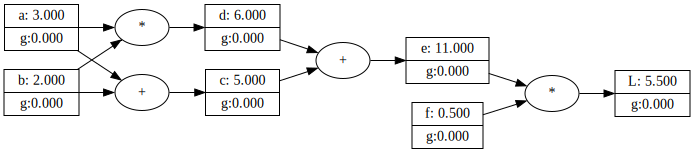

In [42]:
draw_dot(L)

Now we have to calculate the gradient of loss function, L, with respect to each node. We know that the $\frac{\partial L}{\partial L} = 1$, and by the above computation graph we can deduce that:
$$
\begin{align}
\frac{\partial L}{\partial f} &= e, \\
\frac{\partial L}{\partial e} &= f, \\
\frac{\partial L}{\partial c} &= \frac{\partial L}{\partial e}\frac{\partial e}{\partial c} = f \times 1 = f
\end{align}
$$

we can see that the role of a plus node is to just pass on the gradient to the previous nodes in the compuation graph.

In [43]:
L.grad = 1
f.grad = e.data
e.grad = f.data
c.grad = e.grad
d.grad = e.grad

Now we can do the same for the previous add and mul nodes:

$$
\begin{align}
\frac{\partial L}{\partial a} &= \frac{\partial L}{\partial d} \frac{\partial d}{\partial a} + 
\frac{\partial L}{\partial c}\frac{\partial c}{\partial a} \\
&= 0.5 \times b + 0.5 \times 1 = 0.5 \times 2 + 0.5 = 1.5
\end{align}
$$

$$
\begin{align}
\frac{\partial L}{\partial b} &= \frac{\partial L}{\partial c} \frac{\partial c}{\partial b} + 
\frac{\partial L}{\partial d}\frac{\partial d}{\partial b} \\
&= 0.5 \times 1 + 0.5 \times a = 0.5 \times 1 + 0.5 * 3 = 2
\end{align}
$$

In [44]:
a.grad = 1.5
b.grad = 2

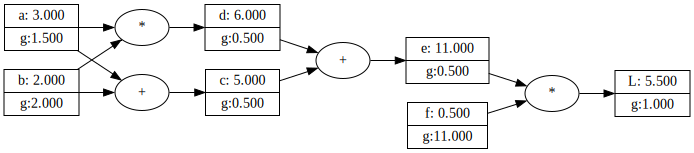

In [45]:
draw_dot(L)

Now we can actually use these backpropagated grads to reduce the final loss in each iteration, we need to just nudge the values by the grads, in the opposite direction of the grad:

In [46]:
a.data -= 0.01 * a.grad
b.data -= 0.01 * b.grad
f.data -= 0.01 * f.grad
c = a + b
d = a * b
e = c + d
L = e * f
L

Value(data=4.241366999999999, label=)

We can now apply this manual backpropagation to an actual perceptron that gets two input arrays, $w_i$ and $x_i$, and outputs an activation function, e.g. $tanh$, applied to $w_i*x_i + b$, e.g. $tanh(w1*x1 + w2*x2 + b)$

In [94]:
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
# bias of the neuron
b = Value(6.8813, _label='b')
wx1 = w1 * x1; wx1._label = "wx1"
wx2 = w2 * x2; wx2._label = "wx2"
wx12 = wx1 + wx2; wx12._label = "wx12"

n = wx12 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'

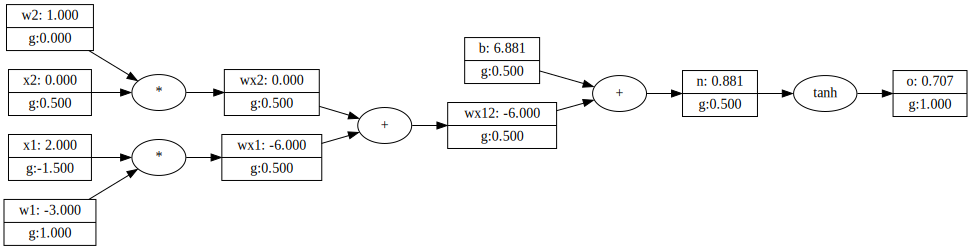

In [85]:
draw_dot(o)

In [34]:
# manual backprop
o.grad = 1.0
# we want now do/dn, o = tanh(n)
# tanh(x)' = 1 - tanh^2(x) = 1 - o^2
n.grad = 1 - o.data**2
n.grad

0.6347395899824584

In [35]:
# we know that the plus operation just flows the grad backward
wx12.grad = n.grad
b.grad = n.grad

In [36]:
# again coming backwards we have another plus node, it will flow the grad backward
wx1.grad = wx12.grad
wx2.grad = wx12.grad

In [37]:
# for the mul node, the local chain rule says:
x1.grad = w1.data * wx1.grad
w1.grad = x1.data * wx1.grad

x2.grad = w2.data * wx2.grad
w2.grad = x2.data * wx2.grad

In [78]:
o.grad = 1.0
o._backward()

In [80]:
n._backward()

In [81]:
wx12._backward()

In [82]:
b._backward()

In [84]:
wx1._backward()
wx2._backward()

Now we have to sort our computatinoal graph (topological sort), to have the dependencies in place, so that the nodes flow from left to right, to be able to backprop from last node to the root node.

In [86]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.8813, label=b),
 Value(data=-3.0, label=w1),
 Value(data=2.0, label=x1),
 Value(data=-6.0, label=wx1),
 Value(data=0.0, label=x2),
 Value(data=1.0, label=w2),
 Value(data=0.0, label=wx2),
 Value(data=-6.0, label=wx12),
 Value(data=0.8813000000000004, label=n),
 Value(data=0.7070699857622339, label=o)]

In [88]:
# set all the grads to zero up there, then do it automatically the backrpop in reverse topological order
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

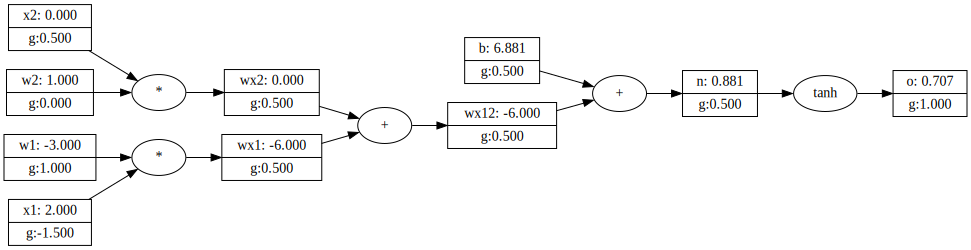

In [96]:
draw_dot(o)

In [95]:
# after adding the backward method to Value class, we can do:
o.backward()

In [156]:
class Neuron:
    def __init__(self, nin):
        # nin: number of inputs to the neuron
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))
    
    # Neuron(x)
    def __call__(self, x):
        # forward pass of the neuron
        # w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [157]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.16195826725315635, label=)

In [158]:
class Layer:
    def __init__(self, nin, nout):
        # nin: number of inputs to the neuron as in Neuron class
        # nout: how many neurons in a layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

In [159]:
x = [2.0, 3.0]
# 5 neurons, each gets 2 inputs
n = Layer(2, 5)
n(x)

[Value(data=-0.17051476214336575, label=),
 Value(data=-0.9768495397231712, label=),
 Value(data=0.9864254805917516, label=),
 Value(data=-0.9874980853608422, label=),
 Value(data=0.6236358614430725, label=)]

In [169]:
# multi-layer perceptron
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [170]:
x = [2.0, 3.0, -1.0]
# 3 inputs, 2 layers of of 4 and 1 output
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7596112291147595, label=)

In [171]:
# an example with four data points
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# targets, a binary classifier
ys = [1.0, -1.0, -1.0, 1.0]

In [188]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7556356844743229, label=),
 Value(data=0.8112703783704742, label=),
 Value(data=0.8522988823523601, label=),
 Value(data=0.5473332343587524, label=)]

In [189]:
# the mean squared error loss function
[(yout - ygt)**2 for yout, ygt in zip(ypred, ys)]

[Value(data=0.059713918702332655, label=),
 Value(data=3.280700383562321, label=),
 Value(data=3.431011149563802, label=),
 Value(data=0.2049072007161082, label=)]

In [190]:
loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
loss

Value(data=6.976332652544564, label=)

In [191]:
loss.backward()

In [192]:
n.layers[0].neurons[0].w[0].grad

0.2503509940684177

In [193]:
n.layers[0].neurons[0].w[0].data

-0.7557244079634102

In [194]:
n.parameters()

[Value(data=-0.7557244079634102, label=),
 Value(data=0.24925739540585404, label=),
 Value(data=-0.699985101351159, label=),
 Value(data=0.1729268331307846, label=),
 Value(data=-0.06310044242638951, label=),
 Value(data=-0.843383717015965, label=),
 Value(data=0.19103739103887526, label=),
 Value(data=-0.9383271434151034, label=),
 Value(data=-0.1312618708456413, label=),
 Value(data=-0.9974012554985386, label=),
 Value(data=-0.9511956585339513, label=),
 Value(data=0.6000936643554302, label=),
 Value(data=-0.6994587227500823, label=),
 Value(data=0.2262781321214162, label=),
 Value(data=0.8687718462166201, label=),
 Value(data=0.44279482575384105, label=),
 Value(data=0.29960986760700575, label=),
 Value(data=0.3033315960593128, label=),
 Value(data=-0.7418543095089644, label=),
 Value(data=-0.498813672107796, label=),
 Value(data=0.9541442610613339, label=),
 Value(data=0.8360075724283936, label=),
 Value(data=-0.4678702405118484, label=),
 Value(data=-0.7089216100103803, label=),
 

In [195]:
# we do gradient descent here,
# after this if we do the forward pass again and calculate the loss it should be slightly less
for p in n.parameters():
    p.data -= 0.01 * p.grad

In [196]:
ypred

[Value(data=0.7556356844743229, label=),
 Value(data=0.8112703783704742, label=),
 Value(data=0.8522988823523601, label=),
 Value(data=0.5473332343587524, label=)]

In [220]:
# an example with four data points
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# targets, a binary classifier
ys = [1.0, -1.0, -1.0, 1.0]

# learning!
for e in range(10):
    # forward pass 
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
    
    # before doing a backward pass in an epoch don't forget to zero out the grads for the next one!
    for p in n.parameters():
        p.grad = 0.0
        
    # backward pass
    loss.backward()
    
    # gradient descent (stochastic)
    for p in n.parameters():
        p.data -= 0.01 * p.grad
        
    print(f"e: {e}, loss: {loss}")
ypred

e: 0, loss: Value(data=1.1404487168691957e-22, label=)
e: 1, loss: Value(data=1.1404487168691957e-22, label=)
e: 2, loss: Value(data=1.1404487168691957e-22, label=)
e: 3, loss: Value(data=1.1404487168691957e-22, label=)
e: 4, loss: Value(data=1.1404487168691957e-22, label=)
e: 5, loss: Value(data=1.1404487168691957e-22, label=)
e: 6, loss: Value(data=1.1404487168691957e-22, label=)
e: 7, loss: Value(data=1.1404487168691957e-22, label=)
e: 8, loss: Value(data=1.1404487168691957e-22, label=)
e: 9, loss: Value(data=1.1404487168691957e-22, label=)


[Value(data=0.9999999999925672, label=),
 Value(data=-0.9999999999999991, label=),
 Value(data=-0.9999999999999992, label=),
 Value(data=0.999999999992332, label=)]